# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [5]:
import sys
sys.path.append("/Users/shua784/github")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../watershed-workflow")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [6]:
import myfunctions.ATSutils as utils
import myfunctions.general_plots as gp

In [7]:
import os,sys,pickle
import numpy as np
import pandas as pd
import scipy
import scipy.spatial
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import matplotlib.colors as mcolors
import shapely, fiona
import logging
import pandas
pandas.options.display.max_columns = None


import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

In [9]:
watershed_name = "Neversink"
meshRes = "100m"
# fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"./meshes/{watershed_name}_mesh-{meshRes}.exo"

# fig_mesh = "./figures/{}_mesh.png".format(watershed_name)
# fig_mesh3D = "./figures/{}_mesh3D.png".format(watershed_name)
# fig_soil_type = "./figures/{}_soil_type.png".format(watershed_name)
# fig_geol_map = "./figures/{}_geol_map.png".format(watershed_name)
# fig_land_cover = "./figures/{}_land_cover.png".format(watershed_name)
# fig_hru = "./figures/{}_HRU.png".format(watershed_name)
# fig_DTB = "./figures/{}_DTB.png".format(watershed_name)

# fname_mesh_pickle = f'./results/{watershed_name}_mesh.p'
fname_soil_id = f'/Users/shua784/github/east-taylor/data/material/{watershed_name}_soil_id-{meshRes}.txt'
fname_geol_id = f'/Users/shua784/github/east-taylor/data/material/{watershed_name}_geol_id-{meshRes}.txt'

fname_soil_prop = f"/Users/shua784/github/east-taylor/data/material/{watershed_name}_soil_prop-{meshRes}.csv"
fname_geol_prop = f"/Users/shua784/github/east-taylor/data/material/{watershed_name}_geol_prop-{meshRes}.csv"

fname_nlcd = f"/Users/shua784/github/east-taylor/data/material/{watershed_name}_nlcd-{meshRes}.csv"

In [10]:
# specify the input shapefile and a hint as to what HUC it is in.
watershed_shapefile = '/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Delaware_River_Basin/GIS/Neversink/Neversink.shp'

# fname_dem = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_DEM/GreaterEastTayor_dem_10m.tif"
# fname_soil = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/gNATSGO/gNATSGO_CO_raster/MapunitRaster_10m1.tif"
fname_DTB = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif"
# fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Upper_Colorado_River_Basin/GIS/EastTaylor_GLHYMPS/EastTaylor_GLHYMPS_v2.shp"
fname_geology = "/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/GLHYMPS_v2/GLHYMPS.shp"

In [11]:
hucs = ['020401040301','020401040302','020401040303'] 
# crs = workflow.crs.daymet_crs()

crs = workflow.crs.from_epsg("26918")
# crs

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [8]:
# specify the input shapefile and a hint as to what HUC it is in.
# watershed_shapefile = watershed_shapefile



# logging.info("")
# logging.info("Meshing shape: {}".format(watershed_shapefile))
# logging.info("="*30)

# # get the shape and crs of the shape
# crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)

2021-07-16 14:36:18,690 - root - INFO: 
2021-07-16 14:36:18,691 - root - INFO: Meshing shape: /Users/shua784/OneDrive - PNNL/Projects/Exasheds/Delaware_River_Basin/GIS/Neversink/Neversink.shp
2021-07-16 14:36:18,691 - root - INFO: ==============================
2021-07-16 14:36:18,691 - root - INFO: 
2021-07-16 14:36:18,692 - root - INFO: Loading shapes
2021-07-16 14:36:18,692 - root - INFO: ------------------------------
2021-07-16 14:36:18,693 - root - INFO: Loading file: '/Users/shua784/OneDrive - PNNL/Projects/Exasheds/Delaware_River_Basin/GIS/Neversink/Neversink.shp'
2021-07-16 14:36:18,731 - root - INFO: ... found 1 shapes
2021-07-16 14:36:18,732 - root - INFO: Converting to shapely


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [13]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-07-16 23:21:09,842 - root - INFO: Using sources:
2021-07-16 23:21:09,842 - root - INFO: --------------
2021-07-16 23:21:09,843 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-07-16 23:21:09,843 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-07-16 23:21:09,844 - root - INFO: DEM: National Elevation Dataset (NED)
2021-07-16 23:21:09,844 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-07-16 23:21:09,845 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-07-16 23:21:09,845 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-07-16 23:21:09,846 - root - INFO: soil thickness: None
2021-07-16 23:21:09,846 - root - INFO: meteorology: DayMet 1km


In [14]:
# load the hucs
my_hucs = []

for huc in hucs:
    _, watersheds = workflow.get_hucs(sources['HUC'], huc, len(huc), crs)
    assert(len(watersheds) == 1)
    my_hucs.extend(watersheds)
watershed = workflow.split_hucs.SplitHUCs(my_hucs)

# load the huc
#_, watershed = workflow.get_split_form_hucs(sources['HUC'], huc, len(huc), crs)

2021-07-16 23:21:11,687 - root - INFO: 
2021-07-16 23:21:11,687 - root - INFO: Loading level 12 HUCs in 020401040301
2021-07-16 23:21:11,688 - root - INFO: ------------------------------
2021-07-16 23:21:11,691 - root - INFO: Using HUC file "/Users/shua784/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_0204_GDB/NHDPlus_H_0204.gdb"
2021-07-16 23:21:11,925 - root - INFO: ... found 1 HUCs
2021-07-16 23:21:11,925 - root - INFO:   -- 020401040301
2021-07-16 23:21:11,937 - root - INFO: Converting to out_crs
2021-07-16 23:21:11,996 - root - INFO: Converting to shapely
2021-07-16 23:21:11,998 - root - INFO: 
2021-07-16 23:21:11,998 - root - INFO: Loading level 12 HUCs in 020401040302
2021-07-16 23:21:11,999 - root - INFO: ------------------------------
2021-07-16 23:21:12,000 - root - INFO: Using HUC file "/Users/shua784/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_0204_GDB/NHDPlus_H_0204.gdb"
2021-07-16 23:21:12,189 - root - INFO: ... found 1 HUCs
2021-07-16 23

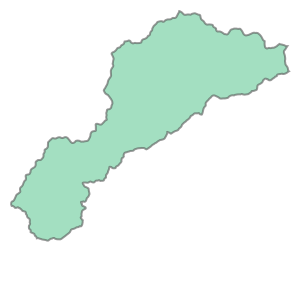

In [15]:
watershed.exterior()

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [16]:
with open("./results/Neversink_rivers_ignore2_prune1_simplify30.p", "rb") as f:
    rivers = pickle.load(f)

In [20]:
# huc = '17030003'
# huc = '02040104' # provide the HUC8/HUC12 for NHD or HUC4 for NHDPlus that includes that watershed
simplify = 30 # length scale to target average edge

rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, cut_intersections=True,
                                         ignore_small_rivers=2, prune_by_area_fraction=0.01
                                        )

else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)



2021-07-16 23:24:02,764 - root - INFO: 
2021-07-16 23:24:02,765 - root - INFO: Loading Hydrography
2021-07-16 23:24:02,765 - root - INFO: ------------------------------
2021-07-16 23:24:02,766 - root - INFO: Loading streams in HUC 020401040303
2021-07-16 23:24:02,766 - root - INFO:          and/or bounds (523886.5845770719, 4629547.658826506, 553236.026762147, 4653792.427938574)
2021-07-16 23:24:02,768 - root - INFO:   Using Hydrography file "/Users/shua784/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_0204_GDB/NHDPlus_H_0204.gdb"
2021-07-16 23:24:02,768 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/shua784/github/watershed-workflow/examples/data/hydrography/NHDPlus_H_0204_GDB/NHDPlus_H_0204.gdb' layer 'NHDFlowline' for streams in '(523886.5845770719, 4629547.658826506, 553236.026762147, 4653792.427938574)'
2021-07-16 23:24:06,220 - root - INFO:   Filtering reaches not in-network
2021-07-16 23:24:06,221 - root - INFO:  

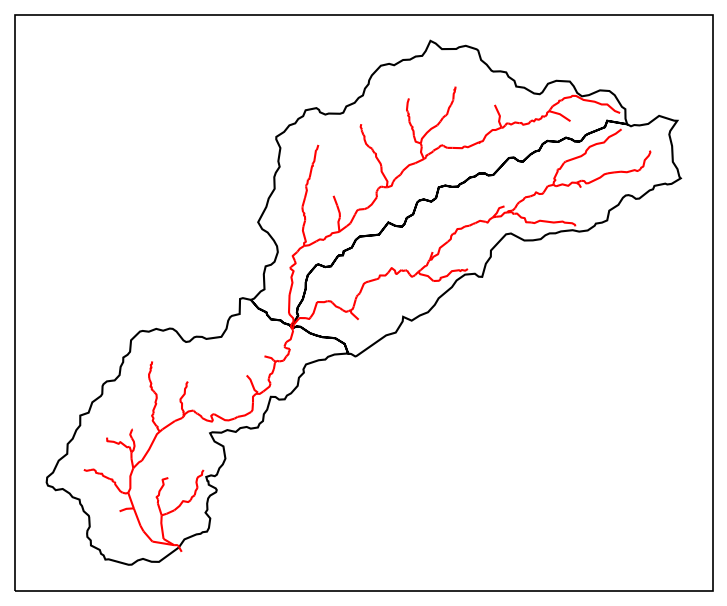

In [21]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

In [23]:
with open("./results/Neversink_watershed_rivers_ignore2_prune1_simplify30.p", "wb") as f:
    pickle.dump((watershed,rivers), f, protocol=-1)

2021-07-16 23:43:23,841 - root - INFO: 
2021-07-16 23:43:23,842 - root - INFO: Meshing
2021-07-16 23:43:23,842 - root - INFO: ------------------------------
2021-07-16 23:43:23,846 - root - INFO: Triangulating...
2021-07-16 23:43:23,848 - root - INFO:    364 points and 366 facets
2021-07-16 23:43:23,849 - root - INFO:  checking graph consistency
2021-07-16 23:43:23,849 - root - INFO:  tolerance is set to 1
2021-07-16 23:43:23,852 - root - INFO:  building graph data structures
2021-07-16 23:43:23,855 - root - INFO:  triangle.build...
2021-07-16 23:43:32,180 - root - INFO:   ...built: 11761 mesh points and 23092 triangles
2021-07-16 23:43:32,181 - root - INFO: Plotting triangulation diagnostics
2021-07-16 23:43:35,053 - root - INFO:   min area = 1364.703369140625
2021-07-16 23:43:35,053 - root - INFO:   max area = 49996.36181640625


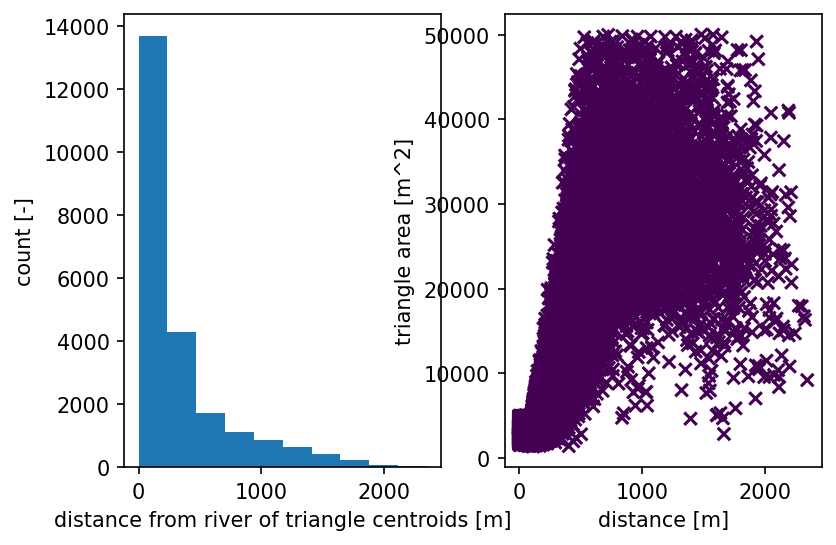

In [22]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
# A0 = 50; A1 = 50000 # [10, 310] m
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500
# A0 = 10000; A1 = 50000 # [140, 310]m
A0 = 5000; A1 = 50000 # [100, 310]m
# A0 = 1000; A1 = 50000 # [45, 310]m
# A0 = 1250; A1 = 50000 # [50, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True,
                                               )

In [24]:
# get a raster for the elevation map, based on NED
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs, crs,
                                                buffer = 300
                                               )

2021-07-16 23:44:36,306 - root - INFO: 
2021-07-16 23:44:36,307 - root - INFO: Loading Raster
2021-07-16 23:44:36,308 - root - INFO: ------------------------------
2021-07-16 23:44:36,309 - root - INFO: Collecting raster
2021-07-16 23:44:36,361 - root - INFO: Collecting DEMs to tile bounds: [-74.72577633586629, 41.80462252951327, -74.34380388996657, 42.04777007116437]
2021-07-16 23:44:36,363 - root - INFO:   Need:
2021-07-16 23:44:36,364 - root - INFO:     /Users/shua784/github/watershed-workflow/examples/data/dem/USGS_NED_1as_n42_w075.tif
2021-07-16 23:44:36,364 - root - INFO:     /Users/shua784/github/watershed-workflow/examples/data/dem/USGS_NED_1as_n43_w075.tif
2021-07-16 23:44:36,366 - root - INFO: source files already exist!
2021-07-16 23:44:36,496 - root - INFO: ... got raster of shape: (876, 1376)
2021-07-16 23:44:36,497 - root - INFO: Warping to out_crs
2021-07-16 23:44:36,605 - root - INFO: ... got raster bounds: (522693.56696110195, 4655288.536203072, 554530.1584259137, 4628

Text(0.5, 1.0, 'smoothed')

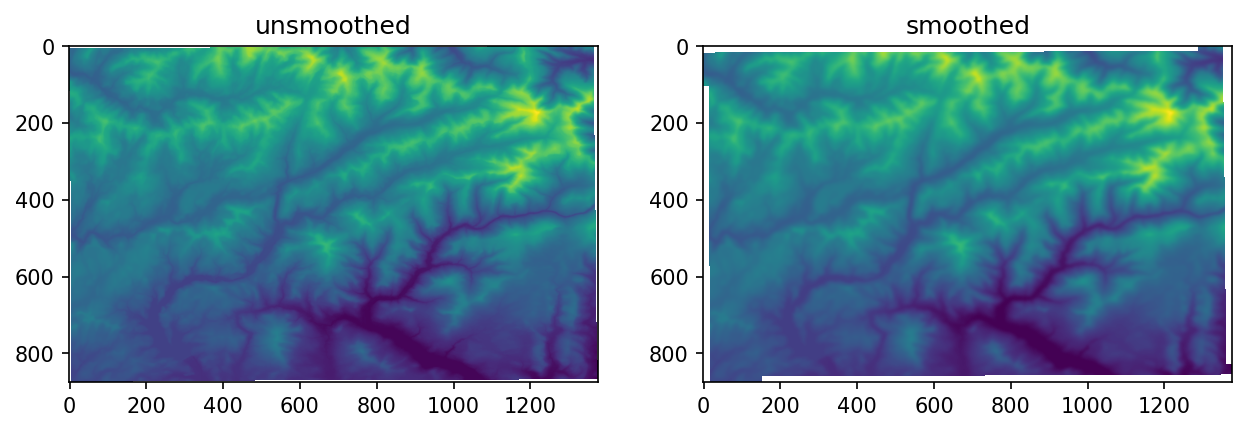

In [25]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 3, mode='nearest')

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')

axs[1].imshow(dem_sm)
axs[1].set_title('smoothed')


### Map mesh to DEM

In [26]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem_sm, dem_profile)

2021-07-16 23:44:44,622 - root - INFO: 
2021-07-16 23:44:44,623 - root - INFO: Elevating Triangulation to DEM
2021-07-16 23:44:44,624 - root - INFO: ------------------------------


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

(522426.1626, 554703.1634, 4628335.42055, 4655004.66645)

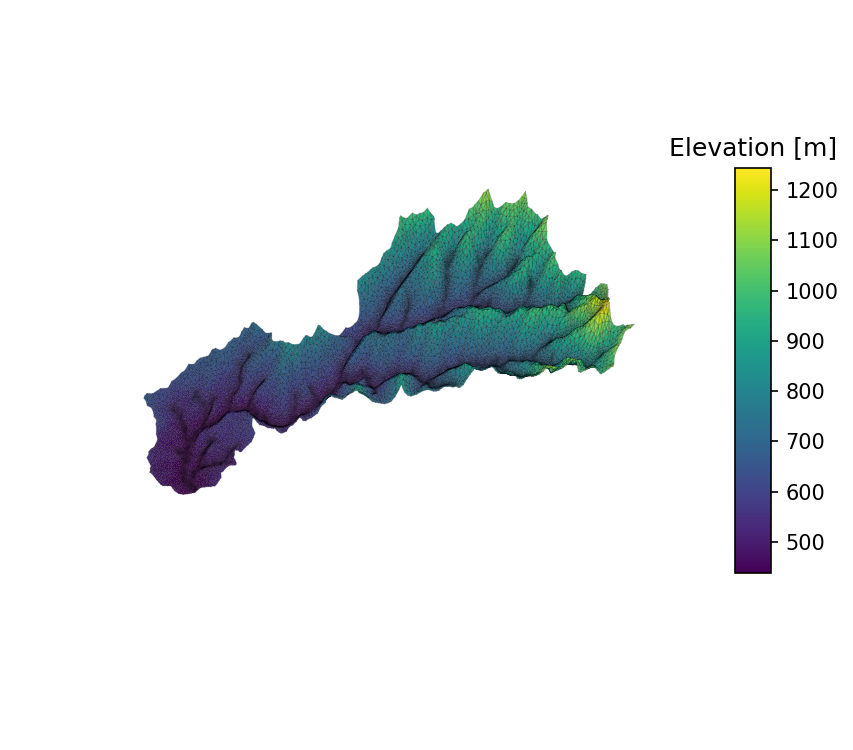

In [91]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
# ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.0, 0.8, 0.8])
# cax = fig.add_axes([0.23,0.18,0.58,0.03])
cax = fig.add_axes([0.7,0.18,0.03,0.45])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="vertical", cax=cax)

t = cax.set_title('Elevation [m]')
ax.view_init(80,-60)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

ax.axis('off')

#fig.savefig('watershed_dem_3d')

In [ ]:
mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)

(522426.1625999999, 554703.1634)
(4628335.42055, 4655004.666450002)


/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


Text(0.5, 1.0, 'Elevation [m]')

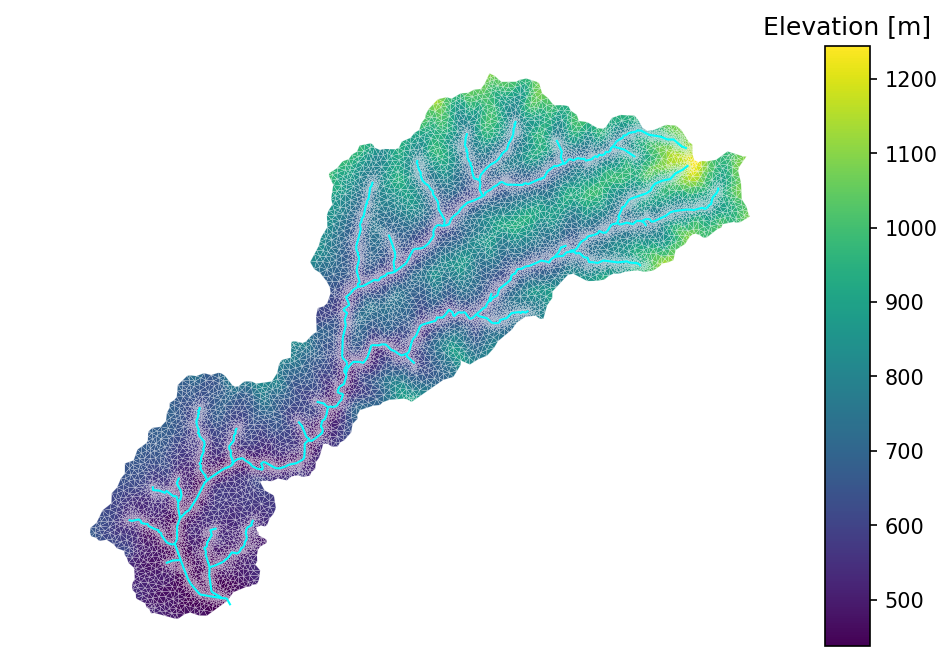

In [68]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(6,5))
ax = workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
# ax2 = ax.inset_axes([0.58,0.45,0.3,0.3])
# cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

# bxlim = (591000., 600000.)
# bylim = (94000., 103000.)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
# workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='aqua', linewidth=1)
ax.set_aspect('equal', 'datalim')
# ax.set_xlim([770000, 800000])
# ax.set_ylim([4520000, 4550000])

# mp2 = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color='elevation', edgecolor='white', linewidth=0.5)
# workflow.plot.hucs(watershed, crs, ax=ax2, color='k', linewidth=1)
# workflow.plot.rivers(rivers, crs, ax=ax2, color='aqua', linewidth=1.5)
# ax2.set_xlim(bxlim)
# ax2.set_ylim(bylim)
# ax2.set_xticks([])
# ax2.set_yticks([])
# ax2.set_aspect('equal', 'datalim')

# ax.indicate_inset_zoom(ax2, edgecolor='r')

# ax.margins(0.5)
ax.axis('off')
# add scalebar, use 1 for UTM coordinates, the default unit is "m"
# scalebar1 = ScaleBar(1, location = "lower left")
# ax.add_artist(scalebar1)
# scalebar2 = ScaleBar(1, location = "upper right")

# ax2.add_artist(scalebar2)

print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('Elevation [m]')

# fig.tight_layout()
# fig.savefig(fig_mesh, dpi = 300, transparent = True)

### construct 2d mesh 

In [28]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

### Hydrologically condition the mesh

Conditions a mesh, in place, by removing artificial pits. 

2021-07-16 23:46:36,533 - root - INFO: max diff = 11.773210611092793 


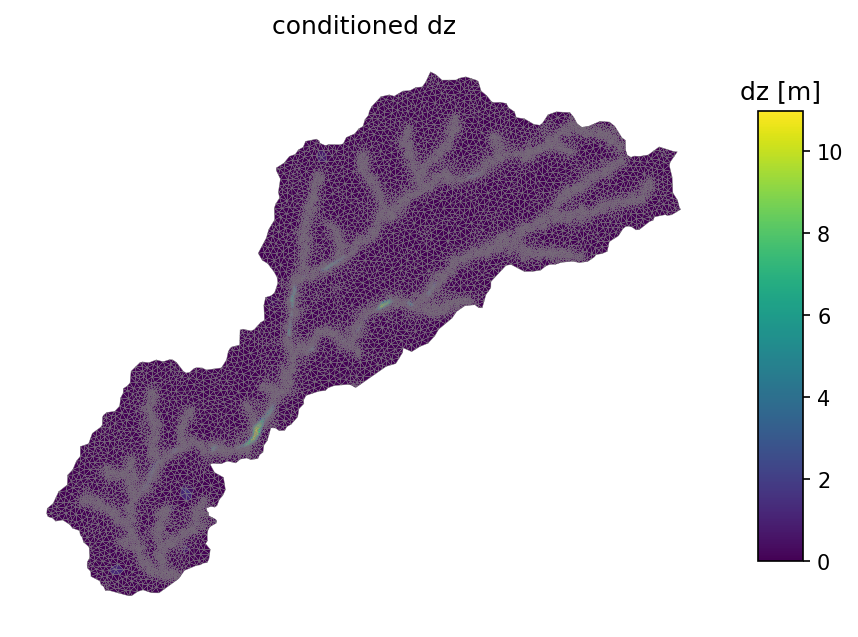

In [32]:
# hydrologically condition the mesh, removing pits
workflow.condition.fill_pits(m2)

# hydrologically condition the mesh, removing pits
# workflow.condition.condition(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
logging.info(f"max diff = {np.abs(diff[:,2]).max()} ")
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
cbax = fig.add_axes([.95,0.25,0.05,0.5])

mp = workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
cbar.ax.set_title('dz [m]')
ax.axis('off')
ax.set_title('conditioned dz')
plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [33]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-07-16 23:46:41,806 - root - INFO: 
2021-07-16 23:46:41,807 - root - INFO: Loading Raster
2021-07-16 23:46:41,808 - root - INFO: ------------------------------
2021-07-16 23:46:41,809 - root - INFO: Collecting raster
2021-07-16 23:46:41,850 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-07-16 23:46:41,978 - root - INFO: ... got raster of shape: (901, 846)
2021-07-16 23:46:41,990 - root - INFO: ... got raster bounds:

In [34]:
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

In [35]:
# if len(nlcd_indices) != len(nlcd_labels):
#     nlcd_labels = [i for i in nlcd_labels if i]
#     assert(len(nlcd_indices) == len(nlcd_labels))

area_list = [areas[lc==i].sum() for i in nlcd_indices]
area_coverage = np.array(area_list) / areas.sum() * 100

nlcd_df = pd.DataFrame([nlcd_indices, nlcd_labels, area_list]).T
nlcd_df.columns = ['id', 'name', 'area']
nlcd_df.set_index('id', inplace = True)

nlcd_df['coverage [%]'] = area_coverage

In [66]:
nlcd_df.to_csv(fname_nlcd)

/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(522426.1626, 554703.1634, 4628335.42055, 4655004.66645)

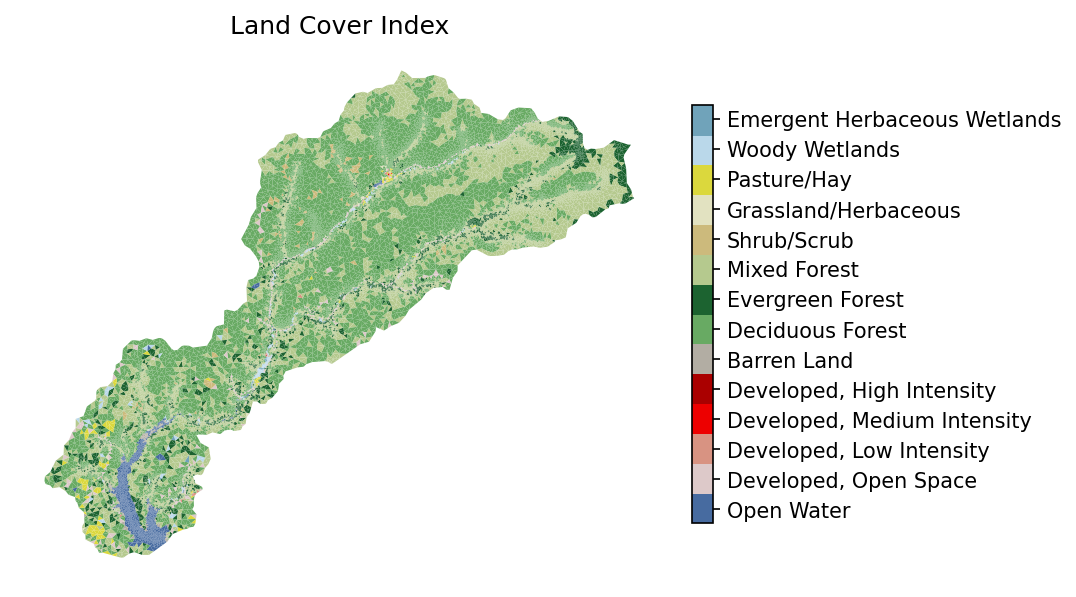

In [67]:
# plot the image
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ax.axis('off')
# fig.tight_layout()
# fig.savefig(fig_land_cover, dpi = 300, transparent = True)

## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [36]:
# download the NRCS soils data as shapes and project it onto the mesh
import matplotlib.cm

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], target_bounds, 
                                                                   in_crs = crs, out_crs = crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-07-16 23:46:55,777 - root - INFO: target bounds: (523893.29908542644, 4629547.6589798955, 553236.026762147, 4653792.427938574)
2021-07-16 23:46:55,778 - root - INFO: 
2021-07-16 23:46:55,778 - root - INFO: Loading shapes
2021-07-16 23:46:55,779 - root - INFO: ------------------------------
2021-07-16 23:46:55,949 - root - INFO: Attempting to download source for target '/Users/shua784/github/watershed-workflow/examples/data/soil_structure/SSURGO/SSURGO_-74.7124_41.8159_-74.3567_42.0359.shp'
2021-07-16 23:46:56,101 - root - INFO:   Found 5575 shapes.
2021-07-16 23:46:56,111 - root - INFO:   and crs: +init=epsg:4326 +type=crs
2021-07-16 23:46:56,160 - root - INFO: found 177 unique MUKEYs.
2021-07-16 23:47:08,861 - root - INFO: Running Rosetta for van Genutchen parameters
2021-07-16 23:47:08,862 - root - INFO:   database: ../../watershed-workflow/workflow_tpls/rosetta/sqlite/rosetta.sqlite
2021-07-16 23:47:08,862 - root - INFO:   model type: 3
2021-07-16 23:47:09,155 - root - INFO:   

In [37]:
area_list = [areas[soil_color==i].sum() for i in np.unique(soil_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

soil_survey_props.set_index('mukey', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
soil_id_df = pd.DataFrame(np.array(np.unique(soil_color, return_counts=True)).T, columns = ['mukey', 'count'])
soil_id_df.set_index('mukey', inplace = True)
soil_id_df['area'] = area_list
soil_id_df['coverage [%]'] = area_coverage

soil_prop_df = soil_survey_props.merge(soil_id_df, how = 'inner', left_on='mukey', right_on = 'mukey', sort = True)

In [100]:
soil_prop_df

residual saturation [-]  Rosetta porosity [-]  \
mukey                                                   
295043                 0.225381              0.394974   
295044                 0.179886              0.428769   
295045                 0.179886              0.428769   
295046                 0.178941              0.411958   
295047                 0.179127              0.412175   
...                         ...                   ...   
295557                 0.173092              0.397934   
295558                 0.173092              0.397934   
295563                      NaN                   NaN   
295570                 0.190380              0.356436   
295571                 0.190337              0.356560   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
mukey                                                      
295043                     0.000054             1.422063   
295044                     0.000069             1.473801   
295045                     0.000069             1.473801   
295046                     0.000060             1.491763   
295047                     0.000060             1.491840   
...                             ...                  ...   
295557                     0.000101             1.467913   
295558                     0.000101             1.467913   
295563                          NaN                  NaN   
295570                     0.000114             1.411143   
295571                     0.000114             1.411337   

        Rosetta permeability [m^2]  thickness [cm]  permeability [m^2]  \
mukey                                                                    
295043                1.181249e-13          152.00        3.130799e-13   
295044                5.226333e-13           66.65        2.975060e-13   
295045                5.226333e-13           66.65        2.975060e-13   
295046                4.141073e-13           86.26        6.117804e-13   
295047                4.131041e-13           88.90        7.733614e-13   
...                            ...             ...                 ...   
295557                4.556812e-13          170.00        1.274242e-12   
295558                4.556812e-13          170.00        1.274242e-12   
295563                         NaN             NaN                 NaN   
295570                1.901016e-13          161.36        1.075479e-13   
295571                1.905490e-13          161.36        1.076481e-13   

        porosity [-]  bulk density [g/cm^3]  total sand pct [%]  \
mukey                                                             
295043      0.378816               1.464474           26.000000   
295044      0.368605               1.239480           44.929798   
295045      0.368605               1.239480           44.929798   
295046      0.287495               1.301781           39.089826   
295047      0.278512               1.301352           38.927673   
...              ...                    ...                 ...   
295557      0.307431               1.368529           53.557059   
295558      0.307431               1.368529           53.557059   
295563           NaN                    NaN                 NaN   
295570      0.275069               1.571404           51.640753   
295571      0.273349               1.570825           51.641502   

        total silt pct [%]  total clay pct [%] source  count          area  \
mukey                                                                        
295043           52.000000           22.000000   NRCS      3  2.950037e+04   
295044           40.867852           14.202350   NRCS     39  5.627761e+05   
295045           40.867852           14.202350   NRCS    214  1.368963e+06   
295046           47.793053           13.117121   NRCS     33  5.827890e+05   
295047           47.900023           13.172304   NRCS     27  4.530791e+05   
...                    ...                 ...    ...    ...           ...   
295557           35.242941

In [101]:
soil_prop_df.to_csv(fname_soil_prop)

(522426.1626, 554703.1634, 4628335.42055, 4655004.66645)

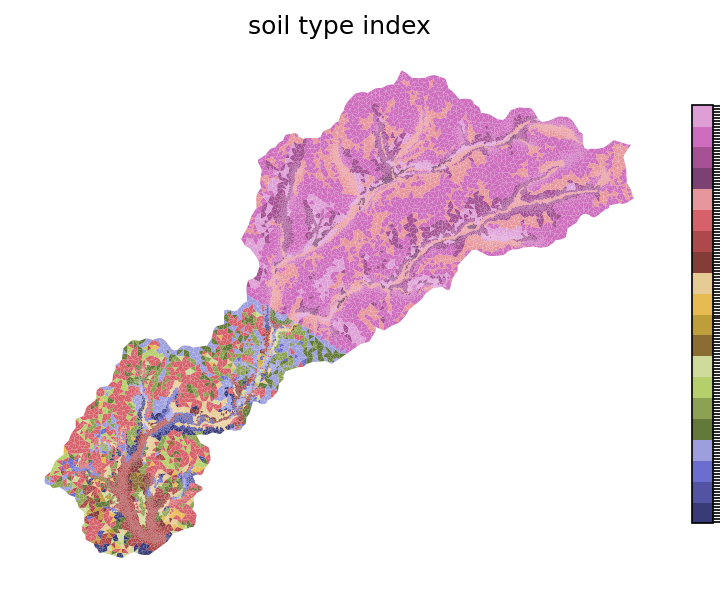

In [39]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap = 'tab20b')

# plot the soil mukey
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = '', fraction = 0.03) 

ax.set_title('soil type index')
ax.axis('off')
# fig.savefig('watershed_soils')

Median soil thickness [m] =  nan


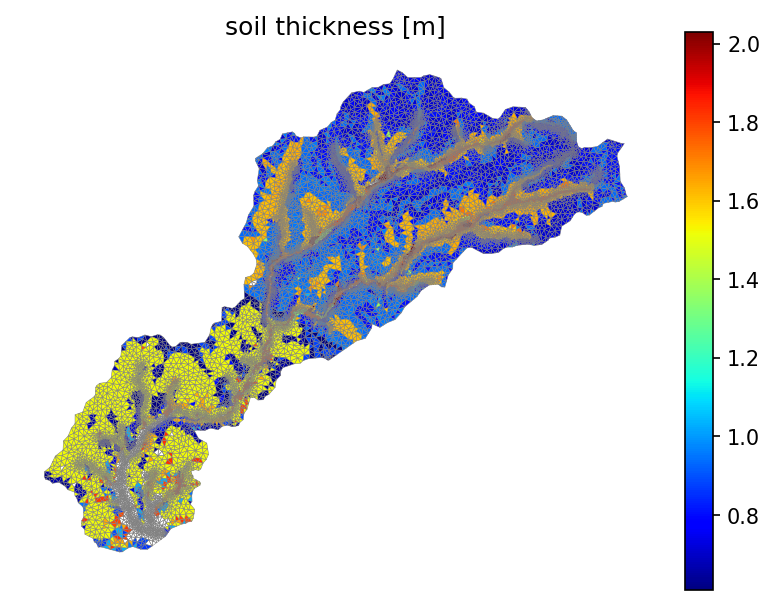

In [108]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'thickness [cm]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop/100, edgecolor='gray', cmap='jet')
# cbar = fig.colorbar(mp)
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.median(iprop)/100)

# fig.savefig('watershed_soil_thickness')


Median soil thickness [m] =  0.27920358284674707


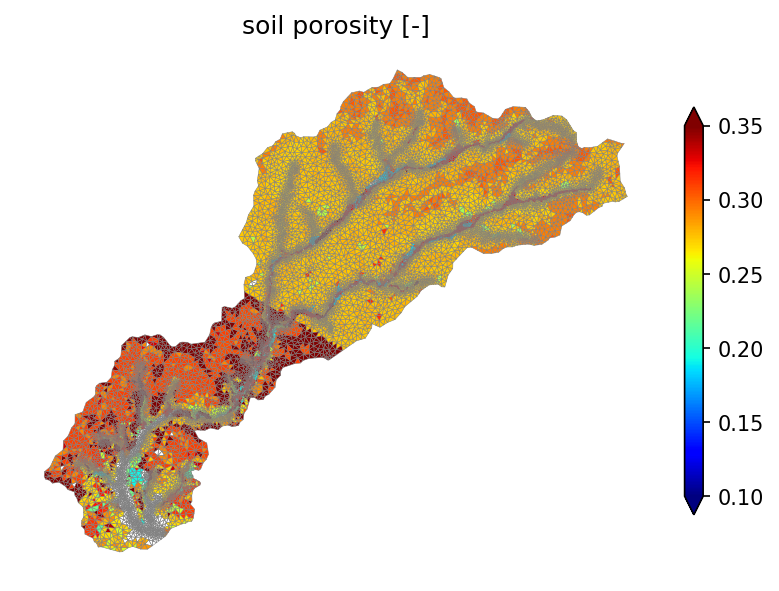

In [109]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet', vmin = 0.1, vmax = 0.35)
# cbar = fig.colorbar(mp)
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median soil thickness [m] = ', np.nanmedian(iprop))

# fig.savefig('watershed_soil_thickness')


/opt/anaconda3/envs/workflow-021121/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


Min k [m^2] =  2.855865203357634e-14


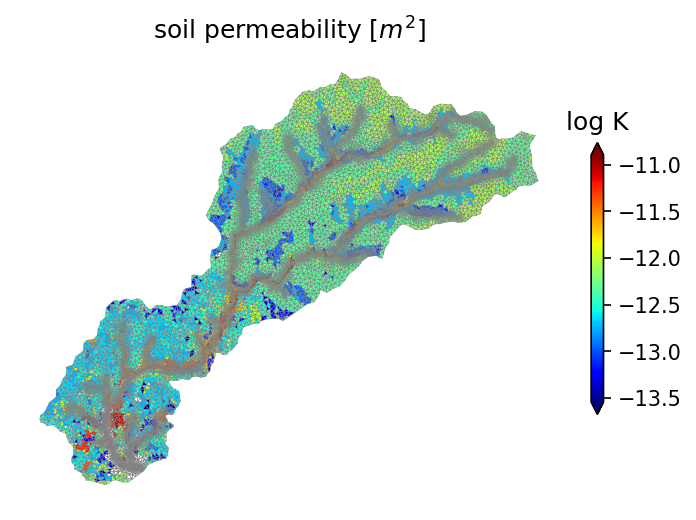

In [71]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('soil permeability [$m^2$]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))

### GLYHMPS geologic layer

In [40]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                                      in_crs = crs, out_crs = crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-07-16 23:54:23,950 - root - INFO: target bounds: (523893.29908542644, 4629547.6589798955, 553236.026762147, 4653792.427938574)
2021-07-16 23:54:23,951 - root - INFO: 
2021-07-16 23:54:23,952 - root - INFO: Loading shapes
2021-07-16 23:54:23,952 - root - INFO: ------------------------------
2021-07-16 23:54:23,953 - root - INFO: Getting shapes of GLHYMPS on bounds: (523893.29908542644, 4629547.6589798955, 553236.026762147, 4653792.427938574)
2021-07-16 23:54:23,953 - root - INFO:   from file: /Users/shua784/github/watershed-workflow/examples/data/soil_structure/GLHYMPS/GLHYMPS.shp
2021-07-16 23:54:24,111 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
../../watershed-workflow/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-07-16 23:54:47,118 - root - INFO: ... found 13 shapes
2021-07-16 23:54:47,118 - root - 

In [41]:
area_list = [areas[geo_color==i].sum() for i in np.unique(geo_color)]
assert(np.sum(area_list) == areas.sum())
area_coverage = np.array(area_list) / areas.sum() * 100

geo_survey_props.set_index('id', inplace = True)
# sub_soil_props = soil_survey_props.loc[unique_soil_id,:]
geo_id_df = pd.DataFrame(np.array(np.unique(geo_color, return_counts=True)).T, columns = ['id', 'count'])
geo_id_df.set_index('id', inplace = True)
geo_id_df['area'] = area_list
geo_id_df['coverage [%]'] = area_coverage

geo_prop_df = geo_survey_props.merge(geo_id_df, how = 'inner', left_on='id', right_on = 'id', sort = True)
# geo_prop_df.to_csv(fname_geol_prop)

(522426.1626, 554703.1634, 4628335.42055, 4655004.66645)

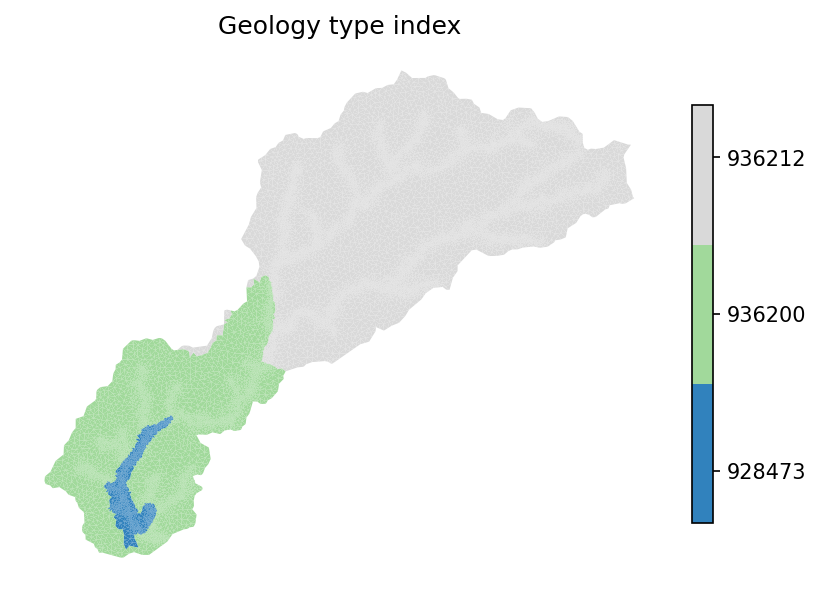

In [42]:
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap = 'tab20c')

# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, 
                        cmap=cmap, norm = norm
                        )

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels = labels) 

ax.set_title('Geology type index')
ax.axis('off')
# print(geo_survey_props)

# fig.savefig('watershed_geology')

In [43]:
np.unique(geo_color)

array([928473, 936200, 936212], dtype=int32)

min = -14.13, max = -10.89637932260933


(522426.1626, 554703.1634, 4628335.42055, 4655004.66645)

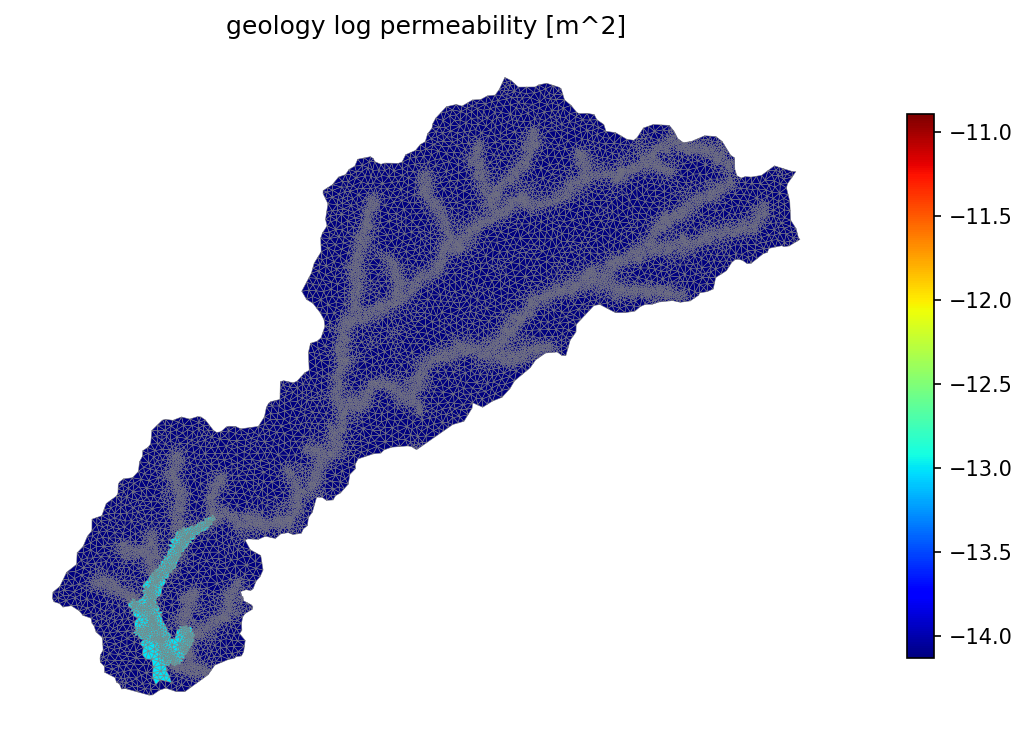

In [122]:
# averaging permeability is a tricky beast.  we average in log space, check that unit conversions make sense
fig = plt.figure(figsize=(12,6))
geol_perm = np.empty(geo_color.shape, 'd')
# soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for i in geo_prop_df.index:
    geol_perm[geo_color == i] = geo_prop_df.loc[i, 'permeability [m^2]']
#     soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[soil_survey_props['mukey'] == mukey, 'Rosetta permeability [m^2]']

pmin = min(np.nanmin(np.log10(geol_perm)), np.nanmin(np.log10(geol_perm)))
# pmax = max(np.nanmax(np.log10(soil_perm_nrcs)), np.nanmax(np.log10(soil_perm_rosetta)))

  
print(f'min = {pmin}, max = {pmax}')

ax1 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=1)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(geol_perm), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, shrink=0.8)
ax1.set_title('geology log permeability [m^2]')
ax1.axis('off')

# ax2 = workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
# mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
#                                  color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
#                                 vmin=pmin, vmax=pmax)
# cbar = fig.colorbar(mp, shrink=0.5)
# ax2.set_title('log permeability (Rosetta) [m^2]')
# ax2.axis('off')


# # fig.savefig('watershed_permeability')



Median porosity =  0.01


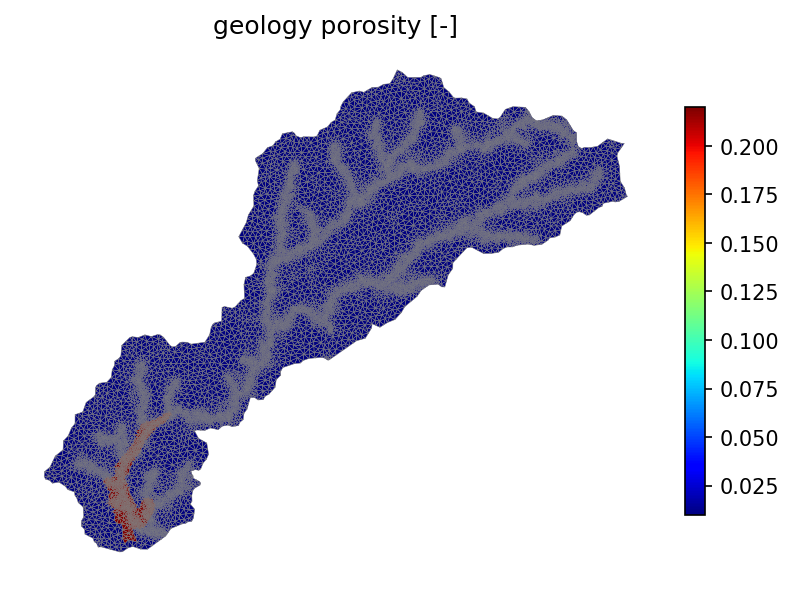

In [123]:
# what do soil thicknesses look like?
fig = plt.figure(figsize=figsize)
iprop = np.empty(geo_color.shape, 'd')

for i in geo_prop_df.index:
    iprop[geo_color == i] = geo_prop_df.loc[i, 'porosity [-]']
# for mukey in geo_prop_df.index:
#     iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

ax = workflow.plot.get_ax(crs, fig)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet', vmin = 0.01, vmax = 0.22)
# cbar = fig.colorbar(mp)
ax.set_title('geology porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04,  shrink = 0.6)
# cb.ax.set_title('[m]')
# cb.set_ticks(nlcd_ticks)
# cb.set_ticklabels(nlcd_labels_fw)
# ax.set_title("Land Cover Index")
ax.axis('off')

print('Median porosity = ', np.nanmedian(iprop))

# fig.savefig('watershed_soil_thickness')


## get bedrock depth

Download global depth to bedrock at 250 m resolution from [soilgrids](http://globalchange.bnu.edu.cn/research/dtb.jsp).

In [44]:
DTB_profile, DTB_raster = workflow.get_raster_on_shape(fname_DTB, watershed.exterior(), crs, nodata=-99999)

2021-07-16 23:55:05,810 - root - INFO: 
2021-07-16 23:55:05,810 - root - INFO: Loading Raster
2021-07-16 23:55:05,811 - root - INFO: ------------------------------
2021-07-16 23:55:05,811 - root - INFO: Loading file: '/Users/shua784/OneDrive - PNNL/Projects/Columbia_Basin/Reach_domain_QGIS/global/depth-to-bedrock/Global_absoluteDTB_M_250m_ll.tif'
2021-07-16 23:55:05,812 - root - INFO: Collecting raster
2021-07-16 23:55:05,932 - root - INFO: ... got raster of shape: (106, 171)
2021-07-16 23:55:05,943 - root - INFO: ... got raster bounds: (-74.71251684599999, 42.03667392, -74.35626690299999, 41.815840621999996)


bounds in my_crs: (-74.71216234655543, 41.8173213871745, -74.35742150648105, 42.0350693972532)


In [45]:
# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB_mesh = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile)
DTB_mesh = np.where(DTB_mesh >= 0, DTB_mesh, np.nan)

In [46]:
logging.info(f'minimum depth-to-bedrock: {np.nanmin(DTB_mesh)} m')
logging.info(f'maximum depth-to-bedrock: {np.nanmax(DTB_mesh)} m')

2021-07-16 23:55:16,554 - root - INFO: minimum depth-to-bedrock: 8.96 m
2021-07-16 23:55:16,554 - root - INFO: maximum depth-to-bedrock: 19.92 m


In [47]:
np.unique(DTB_mesh)

array([8.96, 9.12, 9.25, ...,  nan,  nan,  nan])

### plot depth to bedrock

Text(0.5, 1.0, 'DTB [m]')

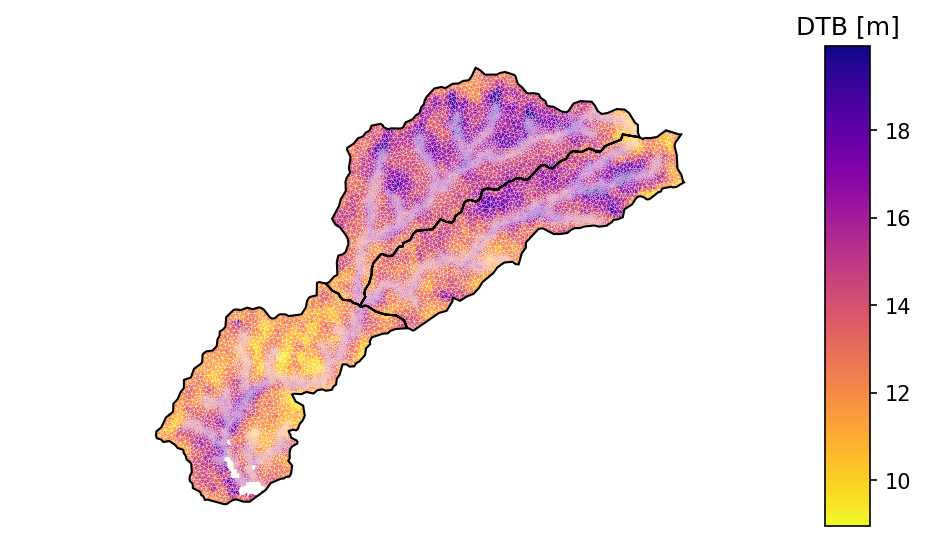

In [132]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB_mesh, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [48]:
total_tckness = np.ceil(np.nanmax(DTB_mesh))
logging.info(f'total thickness: {total_tckness} m')

2021-07-16 23:55:26,437 - root - INFO: total thickness: 20.0 m


In [49]:
ele_per_layer = mesh_tris.shape[0]

In [50]:
def doArraysIntersect(array1, array2):
    return bool(set(array1) & set(array2))

if doArraysIntersect(geo_id_df.index, soil_id_df.index) or doArraysIntersect(geo_id_df.index, [999]) or doArraysIntersect(soil_id_df.index, [999]):
    raise RuntimeWarning('Common id is found in either soil/geol/bedrock!')

In [51]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z_top = []

z = 0.0
z_top.append(z)
# -- soil layer --
#  top 2 m
#  5 cm initial top cell
#  expanding dz, growing with depth
ncells = 6
dz = 0.05
layer_dz = 2 # total top thickness

# tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
tele = 1.75 
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
    dz = round(dz * tele, 2)
    z_top.append(z)    

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
dz = 2.0

geo_ncells = int(np.ceil((total_tckness-z)/dz))
for i in range(geo_ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(geo_color)
    z += dz    
    z_top.append(z)

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-07-16 23:55:29,909 - root - INFO: Got telescoping factor: 1.75
2021-07-16 23:55:29,910 - root - INFO: Cell summary:
2021-07-16 23:55:29,910 - root - INFO: ------------------------------------------------------------
2021-07-16 23:55:29,911 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-07-16 23:55:29,911 - root - INFO: ------------------------------------------------------------
2021-07-16 23:55:29,912 - root - INFO:  00 	| 00 	| 295083 	|   0.050000 	|   0.000000
2021-07-16 23:55:29,912 - root - INFO:  01 	| 01 	| 295083 	|   0.090000 	|   0.050000
2021-07-16 23:55:29,913 - root - INFO:  02 	| 02 	| 295083 	|   0.160000 	|   0.140000
2021-07-16 23:55:29,913 - root - INFO:  03 	| 03 	| 295083 	|   0.280000 	|   0.300000
2021-07-16 23:55:29,914 - root - INFO:  04 	| 04 	| 295083 	|   0.490000 	|   0.580000
2021-07-16 23:55:29,914 - root - INFO:  05 	| 05 	| 295083 	|   0.860000 	|   1.070000
2021-07-16 23:55:29,915 - root - INFO:  06 	| 06 	| 936200 	|   2.000000 	|   1.9300

In [52]:
logging.info(f"No of cells: {len(layer_data)*ele_per_layer}")

2021-07-16 23:55:32,545 - root - INFO: No of cells: 369472


### add bedrock material

In [53]:
# filling missing DTB with max(DTB)
DTB_mesh = np.nan_to_num(DTB_mesh, nan = total_tckness)

In [54]:
# get depth below top cell face
z_top = np.asarray(z_top)
z_center = z_top[:-1] + (z_top[1:]-z_top[:-1])/2

In [55]:
mat_ids = np.stack(layer_mat_ids)

for icol in np.arange(mat_ids.shape[1])[:]:
    idtb = DTB_mesh[icol]
    idx = z_center > idtb
    
    # assign 999 to bedrock
    mat_ids[idx, icol] = 999

In [56]:
layer_mat_ids = [mat_ids[row, :] for row in np.arange(mat_ids.shape[0])]

### extrusion

In [57]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [58]:
ss_names = [m3.side_sets[i].name for i in range(len(m3.side_sets))]
ss_ids = [m3.side_sets[i].setid for i in range(len(m3.side_sets))]

In [59]:
assert(ss_names.index('surface')==1)# surface sideset has id=1
# add back on land cover side sets
surf_ss = m3.side_sets[1] 

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [60]:
with open("./results/Neversink_m3.p", "wb") as f:
    pickle.dump(m3, f, protocol=-1)

In [1]:
# # add "other" landcover type, id=99
# other_idx = np.concatenate([np.where(lc == i)[0] for i in minor_ids])

# ss = workflow.mesh.SideSet('other', 99, 
#                         [surf_ss.elem_list[w] for w in other_idx],
#                         [surf_ss.side_list[w] for w in other_idx])        
# m3.side_sets.append(ss)

In [67]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/Neversink_mesh-100m.exo
Closing exodus file: ./meshes/Neversink_mesh-100m.exo
